In [31]:
from os import environ
from pathlib import Path
from json import loads, dumps
from random import choice
environ["OPENAI_API_KEY"] = Path("~/.openaiapikey").expanduser().read_text().strip()

In [32]:
from openai import OpenAI
from random import randint

openaiClient = OpenAI()
def gpt_3_5_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def gpt_4_turbo_completion(query, temperature = 1):
    answer = openaiClient.chat.completions.create(
        model="gpt-4-turbo",
        messages=[
            {
                "role": "system",
                "content": query
            }
        ],
        temperature = temperature,
        seed = randint(0, 1000000)
    )
    return answer.choices[0].message.content

def tryRecieveAnswer(query, completionFunction = gpt_4_turbo_completion, answerConversion = lambda x: True, maxTries = 10, temperature = 1):
    tryNumber = 0
    while tryNumber < maxTries:
        answer = completionFunction(query, temperature)
        try:
            answer = answerConversion(answer)
            return (answer, True)
        except:
            pass
        tryNumber += 1
    print(f"Failed to recieve answer for query: {query}")
    return (None, False)

def listAnswerConversion(answer):
    result = loads(answer)
    assert isinstance(result, list)
    for item in result:
        assert isinstance(item, str)
    return result

In [6]:
def addTermsToTermListNaive(termListName, topic, newTermsPerIteration = 10, iterations = 10, temperature = 1):
    termList = []
    for i in range(iterations):
        query = f'''The concepts "Stellar evolution", "Brownian motion", "Center of mass" and "Optics" are all part of the topic "Physics".
            Give me a selection of {newTermsPerIteration} specific concepts that belong to subtopics of the topic "{topic}".
            Return them in a list formatted as ["concept1", "concept2", ...]. Return nothing but the list.'''
        def answerConversion(answer):
            result = loads(answer)
            assert isinstance(result, list)
            for concept in result:
                assert isinstance(concept, str)
            return result
        newTerms, success = tryRecieveAnswer(query, answerConversion = answerConversion, temperature = temperature)
        if success:
            termList += newTerms
    path = Path("termlists") / termListName / "termlist.json"
    path.parent.mkdir(parents = True, exist_ok = True)
    if path.exists():
        termList = loads(path.read_text()) + termList
    path.write_text(dumps(termList, indent = 4))


In [10]:
addTermsToTermListNaive("naive_t_1", "Physics", newTermsPerIteration = 10, iterations = 30, temperature = 1)

In [26]:
addTermsToTermListNaive("naive_t_1_2", "Physics", newTermsPerIteration = 10, iterations = 5, temperature = 1.2)

In [29]:
addTermsToTermListNaive("naive_t_1_4", "Physics", newTermsPerIteration = 10, iterations = 30, temperature = 1.4)

In [54]:
# Plot the number of different concepts depending on the number of generated concepts for each term list
# Adds a legend to the plot with the names of the term lists
# Add the diagonal line to the plot as dashed line
def plotNumberOfDifferentConcepts(termListNames, safeAsFileName = None):
    longTermLists = [loads((Path("termlists") / termListName / "termlist.json").read_text()) for termListName in termListNames]
    import matplotlib.pyplot as plt
    plt.plot([i for i in range(max([len(longTermList) for longTermList in longTermLists]))], linestyle = "--", color = "lightgrey")
    for longTermList in longTermLists:
        numbersOfDifferentConcepts = []
        for i in range(len(longTermList)):
            numberOfDifferentConcepts = len(set(longTermList[:i]))
            numbersOfDifferentConcepts.append(numberOfDifferentConcepts)
        plt.plot(numbersOfDifferentConcepts)
    plt.legend(["diagonal"] + termListNames)
    plt.xlabel("Number of generated concepts")
    plt.ylabel("Number of different concepts")
    if safeAsFileName:
        plt.savefig(safeAsFileName)
    plt.show()

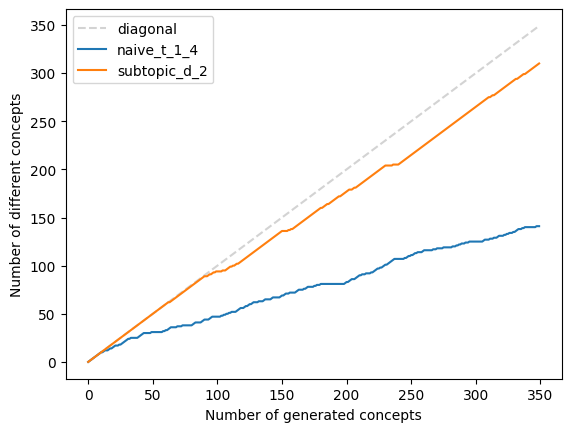

In [59]:
plotNumberOfDifferentConcepts(["naive_t_1_4", "subtopic_d_2"], safeAsFileName = "number_of_different_concepts_subtopic.pdf")

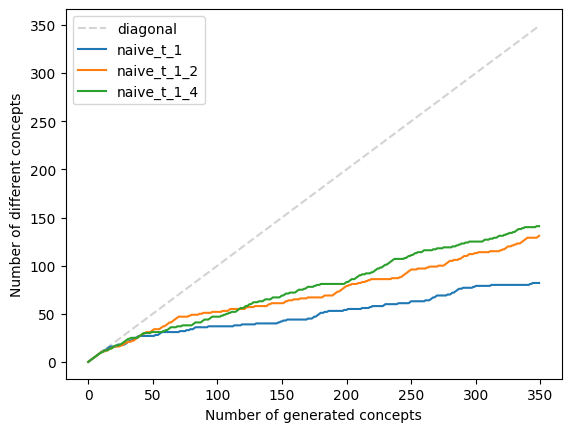

In [57]:
plotNumberOfDifferentConcepts(["naive_t_1", "naive_t_1_2", "naive_t_1_4"], safeAsFileName = "number_of_different_concepts_for_different_temperatures.svg")

In [43]:
def addTermsToTermListSubtopicTreeSupported(termListName, topic, newTermsPerIteration = 10, iterations = 10, subtopicTreeDepht = 10, temperature = 1):
    parentPath = Path("termlists") / termListName
    parentPath.mkdir(parents = True, exist_ok = True)
    subtopicTreePath = parentPath / "subtopic_tree.json"
    subtopicTree = {topic: {}}
    if subtopicTreePath.exists():
        subtopicTree = loads(subtopicTreePath.read_text())
    termList = []
    for i in range(iterations):
        # Walk subTopicTreeDepht steps down the subtopic tree
        currentTopic = topic
        currentDict = subtopicTree[topic]
        for _ in range(subtopicTreeDepht):
            if not currentDict:
                query = f'In which subtopics can the topic "{currentTopic}" be divided? Return nothing but the list of subtopics formatted as: ["subtopic1", "subtopic2", ...]'
                subtopics, success = tryRecieveAnswer(query, temperature = temperature, answerConversion=listAnswerConversion)
                if success:
                    for subtopic in subtopics:
                        currentDict[subtopic] = {}
            if not currentDict:
                break
            currentTopic = choice(list(currentDict.keys()))
            currentDict = currentDict[currentTopic]
        # Add new terms to the term list
        query = f'''The concepts "Stellar evolution", "Brownian motion", "Center of mass" and "Optics" are all part of the topic "Physics".
            Give me a selection of {newTermsPerIteration} specific concepts that belong to subtopics of the topic "{currentTopic} which is a subtopic of the topic "{topic}".
            Return them in a list formatted as ["concept1", "concept2", ...]. Return nothing but the list.'''
        topicTermList, success = tryRecieveAnswer(query, temperature = temperature, answerConversion = listAnswerConversion)
        if success:
            termList += topicTermList
    # Save the term list and the subtopic tree
    path = parentPath / "termlist.json"
    if path.exists():
        termList = loads(path.read_text()) + termList
    path.write_text(dumps(termList, indent = 4))
    subtopicTreePath.write_text(dumps(subtopicTree, indent = 4))


In [60]:
addTermsToTermListSubtopicTreeSupported("subtopic_d_4", "Physics", newTermsPerIteration = 10, iterations = 9, subtopicTreeDepht = 4, temperature = 1)

In [44]:
addTermsToTermListSubtopicTreeSupported("subtopic_d_2", "Physics", newTermsPerIteration = 10, iterations = 5, subtopicTreeDepht = 2, temperature = 1)

In [46]:
# List the most common concepts in the term list
def listMostCommonConcepts(termListName, numberOfCommonConcepts = 10):
    termList = loads((Path("termlists") / termListName / "termlist.json").read_text())
    from collections import Counter
    counter = Counter(termList)
    print(counter.most_common(numberOfCommonConcepts))

In [47]:
listMostCommonConcepts("naive_t_1")

[('Superconductivity', 30), ('Thermodynamics', 26), ('Black holes', 21), ('Nuclear fusion', 20), ('Quantum entanglement', 19), ('Wave-particle duality', 18), ('Electromagnetic spectrum', 18), ('Relativity', 16), ('Fluid dynamics', 12), ('Photonics', 11)]


In [49]:
listMostCommonConcepts("naive_t_1_4")

[('Superconductivity', 25), ('Thermodynamics', 18), ('Nuclear fusion', 18), ('Black holes', 16), ('Quantum entanglement', 14), ('Photoelectric effect', 11), ('Relativity', 11), ('Electromagnetic spectrum', 10), ('Wave-particle duality', 9), ('Fluid dynamics', 9)]
